In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import os
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import pickle
from keras.utils import plot_model
from keras.applications.xception import Xception
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.xception import preprocess_input
from keras.models import Model
import string
import numpy as np
from pickle import load
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM ,GRU
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import Dropout, Reshape, Lambda, Concatenate
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from nltk.translate.bleu_score import corpus_bleu

emb_dim = 100
#snaphot_folder = 'weights3/'
batch_size = 32

Using TensorFlow backend.


In [3]:
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [4]:
def load_doc(filename):
	file = open(filename, 'r',encoding='utf8')
	text = file.read()
	file.close()
	return text

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return list(set(dataset))

def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

#### Reading the captions

In [5]:
doc = load_doc("J:/Flickr_Data/FlickrBn8000/token8K_bn.txt")

In [6]:
descriptions = {}
for line in doc.split('\n'):
    try:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)
    except :
        print(line)

1000268201_693b08cb0e ['একটি ছোট্ট মেয়ে কাঠের প্লে হাউসে উঠছে ।', 'একটি ছোট্ট মেয়ে সিঁড়ি বেয়ে তার প্লে হাউসে উঠছে ।', 'একটি মেয়ে কাঠের ভবনে ঢুকছে ।', 'গোলাপী পোশাকে একটি শিশু প্রবেশের পথে সিঁড়ির একটি সেট উপরে উঠছে ।', 'গোলাপী পোশাকের একটি ছোট্ট মেয়ে কাঠের কেবিনে ঢুকছে ।']


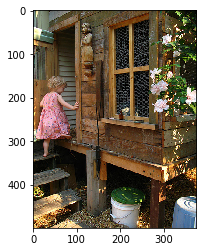

In [7]:
print(next(iter(descriptions)),descriptions[next(iter(descriptions))])

x = plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+next(iter(descriptions))+'.jpg')
plt.imshow(x)
plt.show()

#### Cleaning the data

In [8]:
def clean_data(pairs):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>0]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
            
    return descriptions

In [9]:
#descriptions_clean = clean_data(descriptions)
descriptions[next(iter(descriptions))]

['একটি ছোট্ট মেয়ে কাঠের প্লে হাউসে উঠছে ।',
 'একটি ছোট্ট মেয়ে সিঁড়ি বেয়ে তার প্লে হাউসে উঠছে ।',
 'একটি মেয়ে কাঠের ভবনে ঢুকছে ।',
 'গোলাপী পোশাকে একটি শিশু প্রবেশের পথে সিঁড়ির একটি সেট উপরে উঠছে ।',
 'গোলাপী পোশাকের একটি ছোট্ট মেয়ে কাঠের কেবিনে ঢুকছে ।']

#### Adding start and end token to the sequence of words

In [10]:
start_token = '<startseq>'
end_token = '<endseq>'
def add_end_start_tokens(descriptions):
    for key in descriptions:
        for i in range(len(descriptions[key])):
            descriptions[key][i] = start_token + ' ' + descriptions[key][i] + ' ' + end_token
    return descriptions

In [11]:
descriptions_tokenSE = add_end_start_tokens(descriptions)
descriptions_tokenSE[next(iter(descriptions_tokenSE))]

['<startseq> একটি ছোট্ট মেয়ে কাঠের প্লে হাউসে উঠছে । <endseq>',
 '<startseq> একটি ছোট্ট মেয়ে সিঁড়ি বেয়ে তার প্লে হাউসে উঠছে । <endseq>',
 '<startseq> একটি মেয়ে কাঠের ভবনে ঢুকছে । <endseq>',
 '<startseq> গোলাপী পোশাকে একটি শিশু প্রবেশের পথে সিঁড়ির একটি সেট উপরে উঠছে । <endseq>',
 '<startseq> গোলাপী পোশাকের একটি ছোট্ট মেয়ে কাঠের কেবিনে ঢুকছে । <endseq>']

#### Loading train captions

In [12]:
def load_train_test(descriptions, dataset):
    dataset_ = {}
    for image_id in dataset:
        dataset_[image_id] = descriptions[image_id]
        
    return dataset_

In [13]:
train_imgs_addr = 'J:/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
test_imgs_addr = 'J:/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
dev_imgs_addr = 'J:/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'

train_imgs_names = load_set(train_imgs_addr)
test_imgs_names = load_set(test_imgs_addr)
dev_imgs_names = load_set(dev_imgs_addr)

len(train_imgs_names), len(test_imgs_names), len(dev_imgs_names)

(6000, 1000, 1000)

In [14]:
train_descriptions = load_train_test(descriptions_tokenSE, train_imgs_names)
dev_descriptions = load_train_test(descriptions_tokenSE, dev_imgs_names)
test_descriptions = load_train_test(descriptions_tokenSE, test_imgs_names)

#### reoccuring vocab

In [15]:
# making a vocabulary of the words that occur more than word_count_threshold time
def create_reoccurring_vocab(descriptions, word_count_threshold = 10):
    # Create a list of all the captions
    all_captions = []
    for key, val in descriptions.items():
        for cap in val:
            all_captions.append(cap)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

    return vocab

In [16]:
vocab = create_reoccurring_vocab(train_descriptions, word_count_threshold = 5)
sorted(vocab)[:100]

['2',
 '3',
 '4',
 '5',
 '<endseq>',
 '<startseq>',
 '।',
 'অংশ',
 'অংশটি',
 'অংশে',
 'অংশের',
 'অগভীর',
 'অগ্নিকুণ্ডের',
 'অগ্রভাগে',
 'অঙ্গনে',
 'অঙ্গভঙ্গি',
 'অঞ্চল',
 'অঞ্চলে',
 'অঞ্চলের',
 'অতিক্রম',
 'অতিরিক্ত',
 'অদেখা',
 'অদ্ভুত',
 'অধীনে',
 'অনুভূমিক',
 'অনুশীলন',
 'অনুসরণ',
 'অনেক',
 'অনেকগুলি',
 'অনেকে',
 'অন্তর্বাস',
 'অন্তর্বাসের',
 'অন্ধকার',
 'অন্ধকারযুক্ত',
 'অন্ধকারে',
 'অন্য',
 'অন্যকে',
 'অন্যজন',
 'অন্যটি',
 'অন্যটিকে',
 'অন্যটির',
 'অন্যদিকে',
 'অন্যদের',
 'অন্যভাবে',
 'অন্যরা',
 'অন্যান্য',
 'অন্যের',
 'অপর',
 'অপরকে',
 'অপরের',
 'অপেক্ষা',
 'অপেক্ষায়',
 'অফ',
 'অফ-রোড',
 'অফিসার',
 'অফিসের',
 'অবতরণ',
 'অবরুদ্ধ',
 'অবস্থানে',
 'অবস্থায়',
 'অবস্থিত',
 'অবাক',
 'অভিনব',
 'অভিনয়',
 'অভিন্ন',
 'অভ্যন্তরে',
 'অভ্যর্থনা',
 'অরণ্যে',
 'অর্থ',
 'অর্থের',
 'অর্ধ',
 'অর্ধেক',
 'অল্প',
 'অল্পবয়সী',
 'অস্ত্র',
 'অস্ত্রের',
 'অস্থায়ী',
 'অস্পষ্ট',
 'অ্যাকর্ডিয়ান',
 'অ্যাথলিট',
 'অ্যাথলেটিক',
 'আঁকছে',
 'আঁকছেন।',
 'আঁকড়ে',
 'আঁকা',
 'আঁকেন।',
 'আঁটসাঁট',
 'আংটি',
 'আংশ

In [17]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
tokenizer = keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
tokenizer.fit_on_texts(vocab)
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size :', vocab_size)

vocab_size : 3388


In [18]:
ixtoword = {} # index to word dic
wordtoix = {} # word to index dic

tokenizer.word_index['<PAD0>'] = 0 # no word in vocab has index 0. but padding is indicated with 0
wordtoix = tokenizer.word_index # word to index dic

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

#### finding suitable length for sequences to use in training

In [19]:
# finding the maximum length of questions and answers
# because there are senteces with unusually long lengths, 
# we caculate the max length that p% of data can be placed in
def max_length(desc,p):
    all_desc = []
    # Create a list of all the captions
    for i in desc:
        for j in desc[i]:
            all_desc.append(j)

    length_all_desc = list(len(d.split()) for d in all_desc)

    print('percentile {} of len of questions: {}'.format(p,np.percentile(length_all_desc, p)))
    print('longest sentence: ', max(length_all_desc))

    return int(np.percentile(length_all_desc, p))

max_length = max_length(train_descriptions,90)

print('max-len answer for training: ', max_length)

percentile 90 of len of questions: 15.0
longest sentence:  23
max-len answer for training:  15


In [20]:
# [hi i am home]
# [0 0 0 0 0 0 0 0 0 0 0 50 60 70 80]

In [21]:
# only keep the decriptions that have the words from our vocab
def trimRareWords(desc):
    num_des = 0
    num_trim = 0
    desc_result = desc.copy()
    for d in desc_result:
        desc_result[d]=[]
        
    # Filter out pairs with trimmed words
    i=0
    for d in desc:
        i+=1
        progressBar(value=i, endvalue=len(desc))
        for p in desc[d]:
            num_des += 1
            keep_input = True
            # Check input sentence
            for word in p.split(' '):
                if word not in vocab:
                    keep_input = False
                    break

            # Only keep descriptions that do not contain trimmed word(s) in them
            if keep_input:
                num_trim += 1
                desc_result[d].append(p)

    print("\nTrimmed from {} pairs to {}".format(num_des, num_trim))
    return desc_result


# Trim voc and pairs
# desc_train_final = trimRareWords(train_descriptions)
# with open ('train_descriptions.pkl','wb') as f:
#     pickle.dump(desc_train_final,f)
    
# with open ('train_descriptions.pkl','rb') as f:
#     desc_train_final = pickle.load(f)
    
# len(desc_train_final)

#### feature extractor model Xception

In [22]:
xception = Xception()
extractor = Model(inputs=xception.inputs, outputs=xception.layers[-2].output) # removing 2 last fully connected layers 
print(extractor.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [23]:
def extract_features(description, model, inpute_size = (299,299)):
    directory = 'J:/Flickr_Data/FlickrBn8000/Images/'
    features = {}
    i = 0
    for name in description:
        progressBar(value=i,endvalue=len(descriptions))
        i +=1
        filename =os.path.join(directory, name+'.jpg')
        image = load_img(filename, target_size=inpute_size)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature.reshape(2048)
    return features

In [24]:
train_features = extract_features(train_descriptions, extractor)
test_features = extract_features(test_descriptions, extractor)
dev_features = extract_features(dev_descriptions, extractor)

pickle.dump(train_features, open('J:/Flickr/n6/train_features.pkl', 'wb'))
pickle.dump(test_features, open('J:/Flickr/n6/test_features.pkl', 'wb'))
pickle.dump(dev_features, open('J:/Flickr/n6/dev_features.pkl', 'wb'))
with open('J:/Flickr/n6/dev_features.pkl','rb') as f:
    dev_features= pickle.load(f)    
    
with open('J:/Flickr/n6/train_features.pkl','rb') as f:
    train_features= pickle.load(f)
    print(len(train_features))
with open('J:/Flickr/n6/test_features.pkl','rb') as f:
    test_features= pickle.load(f)


Job Completion: [->                  ] 12%6000


#### Data Genarator

![](model_v2.png)

In [25]:
from numpy import array
def data_generator(descriptions, photos, wordtoix):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==batch_size:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [26]:
d = next(data_generator(dev_descriptions, dev_features,wordtoix))
d[0][0].shape, d[0][1].shape, d[1].shape

((1597, 2048), (1597, 15), (1597, 3388))

#### Word Emeddings glove 

I used wikipedia corpus that includes 400k words in 50d 

download from here: https://github.com/stanfordnlp/GloVe

In [27]:
from numpy import asarray
from pickle import dump
from gensim.models import Word2Vec

from gensim.scripts.glove2word2vec import glove2word2vec 
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import KeyedVectors

from gensim.models.fasttext import FastText

from gensim.models import FastText
lines = [s.split() for s in train_descriptions]
model = FastText(lines, size=100, window=5, workers=8, min_count=1)
model.wv.save_word2vec_format('J:/Flickr/n6/word_vectors.txt'.format(FastText), binary=False)
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

#import fasttext
#.......................................................................................	...............		......................
#filename = open('/content/gdrive/My Drive/bangla/fasttext/100/descriptions.txt')
#pretrained_file =  '/content/gdrive/My Drive/bangla/fasttext/100/glove_vectors.txt'

#model_pre = fasttext.train_unsupervised(filename, model='skipgram', pretrainedVectors= pretrained_file)
#model_pre.save_model('/content/gdrive/My Drive/bangla/fasttext/100/fasttext_model.txt')
#.......................................................................................	..............		.......................


# load the whole embedding into memory
embedding = dict()
file = open('J:/Flickr/n6/word_vectors.txt', encoding='utf8')
for line in file:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embedding[word] = coefs
file.close()
print('Embedding Size: %d' % len(embedding))
 
# summarize vocabulary
all_tokens = ' '.join(train_descriptions).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))
 
# get the vectors for words in our vocab
cust_embedding = dict()
for word in vocabulary:
	# check if word in embedding
	if word not in embedding:
		continue
	cust_embedding[word] = embedding[word]
print('custom embedding words: ',len(cust_embedding))
 
# save
dump(cust_embedding, open('J:/Flickr/n6/fasttext_embedding.pkl', 'wb'))
print('Saved Embedding')

Vocabulary size: 6000
Embedding Size: 6001
Vocabulary Size: 6000
custom embedding words:  6000
Saved Embedding


In [28]:
import numpy as np
# load a word embedding
def load_embedding_fastText(tokenizer, vocab_size, max_length):
	# load the tokenizer
	embedding = load(open('J:/Flickr/n6/fasttext_embedding.pkl', 'rb'))
	dimensions = 100
	trainable = True
	# create a weight matrix for words in training docs
	weights = np.zeros((vocab_size, dimensions))
	# walk words in order of tokenizer vocab to ensure vectors are in the right index
	for word, i in tokenizer.word_index.items():
		if word not in embedding:
			continue
		weights[i] = embedding[word]
	layer = Embedding(vocab_size, dimensions, weights = [weights], input_length = max_length, trainable = trainable, mask_zero=True)
	return layer
 
model_name = 'fastText'

In [29]:
def make_embedding_layer(embedding_dim = 100, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # just a zero matrix 
    else:
        glove_dir = 'J:/Flickr/n6/'
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'bn_glove.39M.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get x-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        print('GloVe loaded!')
        
    embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

In [30]:
# in order to make model faster, I load embd outside the make_model
embedding_layer = make_embedding_layer(emb_dim, glove=True)

GloVe loaded!


#### loss

In [32]:
# for masking pad0 outputs
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

#### Constructing the model

In [33]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0)(inputs1)
fe2 = Dense(256, activation='elu')(fe1)
fe3 = Dropout(0)(fe2)
    
    # sequence model
inputs2 = Input(shape=(max_length,))
se1 = load_embedding_fastText(tokenizer, vocab_size, max_length)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = Bidirectional(GRU(128))(se2)
	#se3 = GRU(128, activation='relu')(se2)
se4 = Dense(256, activation='relu')(se3)   
	#se4 = LSTM(512)(se3)
    
we1 = embedding_layer(inputs2)
we2 = Dropout(0.3)(we1)
we3 = Bidirectional(GRU(128))(we2)
	#we3 = GRU(128, activation='relu')(we2)
we4 = Dense(256, activation='relu')(we3)
       
encoder1 = add([se4, we4])
	#encoder2 = Dense(512, activation='relu')(encoder1)
    
    # decoder model
decoder1 = add([fe3, encoder1])
decoder2 = Dense(256, activation='elu')(decoder1)
decoder3 = Dropout(0.5)(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)
    # tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 15, 100)      338800      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 100)      338800      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
____________________________________________________________________________________________

#### compiling the model

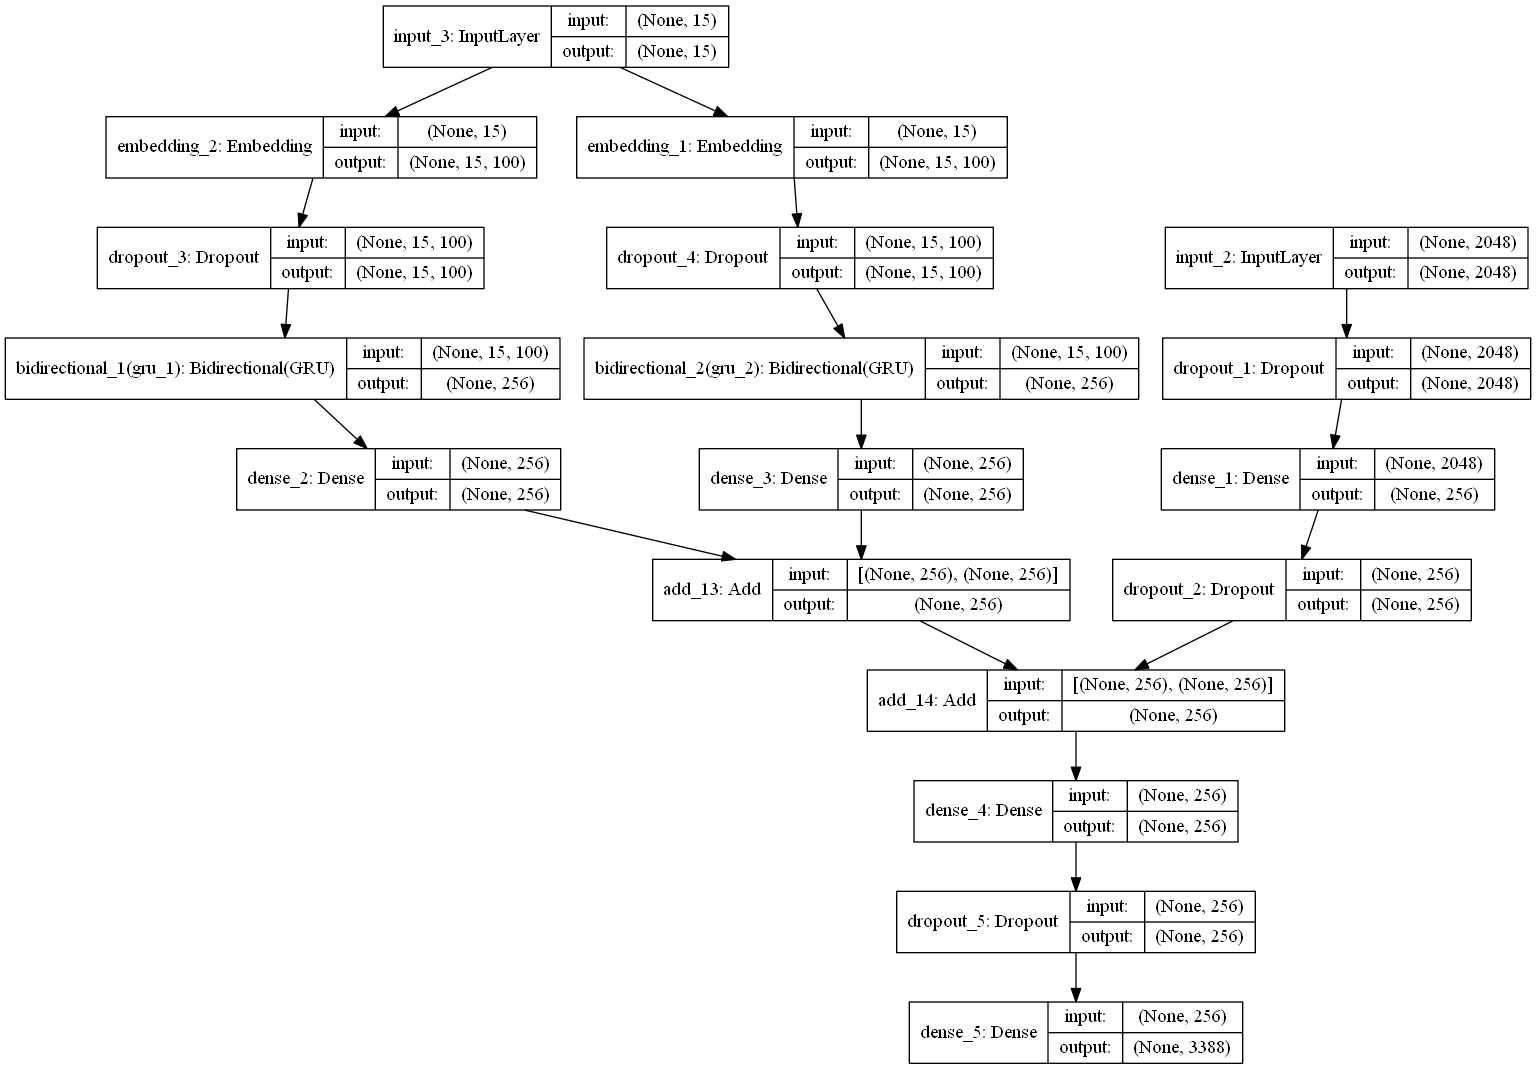

In [34]:
plot_model(model, to_file='J:/Flickr/n6/functional_3.png', show_shapes=True)

In [35]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam',metrics = ['accuracy'])

#### Training the model

In [36]:
history={'loss':[], 'BLEU_val':[]}

In [37]:
# generate a description for an image greedy way
def generate_desc(model, photo_fe, inference= False):
    # seed the generation process
    in_text = start_token
    # iterate over the whole length of the sequence
    # generate one word at each iteratoin of the loop
    # appends the new word to a list and makes the whole sentence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences(in_text.split()) #[wordtoix[w] for w in in_text.split() if w in wordtoix]
        # pad input
        photo_fe = photo_fe.reshape((1,2048))
        sequence = pad_sequences([sequence], maxlen=max_length).reshape((1,max_length))
        # predict next word
        yhat = model.predict([photo_fe,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next v
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == end_token:
            break
            
    if inference == True:
        in_text = in_text.split()
        if len(in_text) == max_length:
            in_text = in_text[1:] # if it is already at max len and endseq hasn't appeared
        else:
            in_text = in_text[1:-1]
        in_text = ' '.join(in_text)
        
    return in_text

In [38]:
def beam_search_pred(model, pic_fe, wordtoix, K_beams = 3, log = False):
    start = [wordtoix[start_token]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words 
                                                                                         # based on the previous steps
            preds = model.predict([pic_fe.reshape(1,2048), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                         # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [39]:
# calculating BLEU score of predictions
def evaluate_model(model, descriptions, photos_fe, K_beams= 3, log=False):
    actual, predicted = list(), list()
    # step over the whole set
    i=0
    for key, desc_list in descriptions.items():
        # generate description
        i+=1
        progressBar(i, len(descriptions), bar_length=20,job='Evaluating')
        if K_beams == 1:
            yhat = generate_desc(model, photos_fe[key])
        else:
            yhat=beam_search_pred(model, photos_fe[key], wordtoix, K_beams = K_beams,log=log)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    # calculate BLEU score
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1,b2,b3,b4]

In [40]:
from keras.callbacks import ReduceLROnPlateau
Reduce_lr=ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.00001)

====


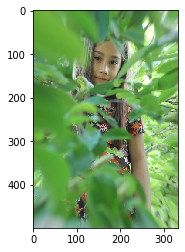

Greedy: কারও ঢিবিতে ঢিবিতে তরঙ্গের ঢিবিতে তরঙ্গের ঢিবিতে ঢিবিতে তরঙ্গের ঢিবিতে তরঙ্গের ঢিবিতে তরঙ্গের ঢিবিতে


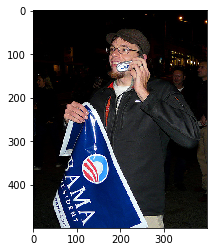

Greedy: কারও খেলনাতে তাকান পতিত পতিত পতিত পতিত পতিত পতিত পতিত পতিত পতিত পতিত পতিত


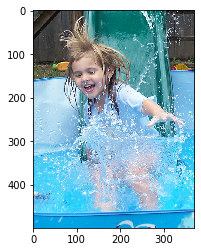

Greedy: চরম চরম চরম চরম চরম চরম চরম চরম চরম চরম চরম চরম চরম চরম


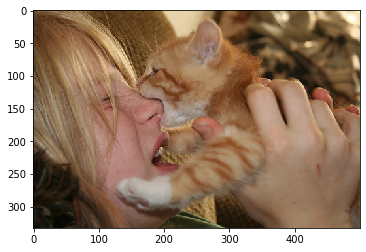

Greedy: সংগ্রহ সংগ্রহ সংগ্রহ সংগ্রহ সংগ্রহ সংগ্রহ সংগ্রহ সংগ্রহ সংগ্রহ সংগ্রহ সংগ্রহ সংগ্রহ সংগ্রহ সংগ্রহ
====


In [41]:
def test(i=6,j=2,k=50,q=888,show_pic=False):
    print('====')
    pic = list(test_features.keys())[i]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[j]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[k]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    pic = list(test_features.keys())[q]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))

    print('====')
    
    
test(show_pic=True)    

In [42]:
epochs = 100
steps = len(train_descriptions)//batch_size

In [43]:
ep=1

In [44]:
for i in range(ep,epochs):
    
    print('Epoch :',i,'\n')
    # create the data generator
    generator = data_generator(train_descriptions, train_features,wordtoix)
    # fit for one epoch
    h = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])
    
    # save model every 10 epochs
    if i % 3 == 0:
        test() 
        model.save_weights('J:/Flickr/n6/model'+'/model_' + str(i) + '.h5')
        belus= evaluate_model(model, dev_descriptions, dev_features, K_beams=1)    
        history['BLEU_val'].append((belus,i))

    print('\n','='*80)

Epoch : 1 



C:\Users\Raihan\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
187/187 [==============================] - 28s 151ms/step - loss: 5.1911 - accuracy: 0.2093

Epoch : 2 

Epoch 1/1
187/187 [==============================] - 26s 138ms/step - loss: 4.3371 - accuracy: 0.2753

Epoch : 3 

Epoch 1/1
187/187 [==============================] - 27s 143ms/step - loss: 4.0522 - accuracy: 0.2940
====
Greedy: একটি মেয়ে একটি লাল রঙের এবং নীল রঙের একটি মেয়ে একটি লাল রঙের এবং
Greedy: একটি ছেলে একটি লাল রঙের এবং সাদা রঙের একটি লাল রঙের এবং সাদা রঙের
Greedy: একটি মেয়ে একটি পুলে পুলে খেলছে ।
Greedy: একটি ছোট ছেলে একটি বড় বড় বড় একটি বড় বড় ।
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.460016
BLEU-2: 0.307929
BLEU-3: 0.219244
BLEU-4: 0.110219

Epoch : 4 

Epoch 1/1
187/187 [==============================] - 24s 130ms/step - loss: 3.8726 - accuracy: 0.3060

Epoch : 5 

Epoch 1/1
187/187 [==============================] - 26s 137ms/step - loss: 3.7441 - accuracy: 0.3136

Epoch : 6 

Epoch 1/1
187/187 [==============================]

187/187 [==============================] - 29s 153ms/step - loss: 2.9034 - accuracy: 0.3829
====
Greedy: একটি ছেলে একটি গাছের নীচে একটি শাখায়
Greedy: একটি লাল এবং সাদা জ্যাকেট পরা একটি লোক একটি পরিষ্কার
Greedy: একটি ছোট ছেলে একটি পুলের মধ্যে দিয়ে ।
Greedy: একটি মেয়ে এবং একটি
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.552530
BLEU-2: 0.370093
BLEU-3: 0.262343
BLEU-4: 0.138967

Epoch : 28 

Epoch 1/1
187/187 [==============================] - 25s 133ms/step - loss: 2.8906 - accuracy: 0.3838

Epoch : 29 

Epoch 1/1
187/187 [==============================] - 26s 138ms/step - loss: 2.8742 - accuracy: 0.3854

Epoch : 30 

Epoch 1/1
187/187 [==============================] - 26s 139ms/step - loss: 2.8560 - accuracy: 0.3882
====
Greedy: একটি মেয়ে এবং একটি মেয়ে একটি গাছের নীচে
Greedy: একটি লোক তার মুখে একটি চিহ্ন বহন করে ।
Greedy: একটি ছোট ছেলে একটি পুলের মধ্যে দিয়ে ।
Greedy: একটি ব্যক্তি এবং একটি মেয়ে তার কোলে বসে ।
====
Evaluating Completion: [-------------------

187/187 [==============================] - 25s 131ms/step - loss: 2.6198 - accuracy: 0.4130

Epoch : 53 

Epoch 1/1
187/187 [==============================] - 26s 138ms/step - loss: 2.6149 - accuracy: 0.4142

Epoch : 54 

Epoch 1/1
187/187 [==============================] - 25s 136ms/step - loss: 2.6034 - accuracy: 0.4153
====
Greedy: একটি শিশু একটি শিলা ঢাকা পাহাড়ের নিচে দাঁড়িয়ে আছে ।
Greedy: একটি লাল জ্যাকেট পরা একটি লোক একটি গাছের সামনে দাঁড়িয়ে আছে ।
Greedy: একটি ছোট ছেলে একটি পুলে স্লাইড করছে ।
Greedy: একটি অল্প বয়সী মেয়ে তার মুখ তুলছে ।
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.541678
BLEU-2: 0.358133
BLEU-3: 0.247649
BLEU-4: 0.125769

Epoch : 55 

Epoch 1/1
187/187 [==============================] - 24s 129ms/step - loss: 2.6058 - accuracy: 0.4154

Epoch : 56 

Epoch 1/1
187/187 [==============================] - 25s 136ms/step - loss: 2.6026 - accuracy: 0.4145

Epoch : 57 

Epoch 1/1
187/187 [==============================] - 26s 141ms/step - loss

187/187 [==============================] - 26s 139ms/step - loss: 2.4841 - accuracy: 0.4292
====
Greedy: একটি শিশু একটি পথ ধরে একটি পথ ধরে একটি পথ ধরে ।
Greedy: একটি কালো জ্যাকেট এবং সাদা জ্যাকেট পরা একটি লোক একটি লাল জ্যাকেট পরা একটি
Greedy: একটি মেয়ে একটি পুলে একটি পুলে স্লাইড করছে ।
Greedy: একটি মেয়ে তার বাম দিকে তাকিয়ে আছে এবং তার মুখ
====
Evaluating Completion: [------------------->] 100%

BLEU-1: 0.503004
BLEU-2: 0.331991
BLEU-3: 0.232068
BLEU-4: 0.118348

Epoch : 79 

Epoch 1/1
187/187 [==============================] - 24s 131ms/step - loss: 2.4853 - accuracy: 0.4288

Epoch : 80 

Epoch 1/1
187/187 [==============================] - 25s 136ms/step - loss: 2.4771 - accuracy: 0.4302

Epoch : 81 

Epoch 1/1
187/187 [==============================] - 26s 139ms/step - loss: 2.4731 - accuracy: 0.4298
====
Greedy: একটি ছোট বাচ্চা একটি পাথরের উপর দিয়ে একটি পাথরে দাঁড়িয়ে আছে ।
Greedy: একটি লাল জ্যাকেটের একটি লোক একটি সাইন বহন করে ।
Greedy: একটি মেয়ে একটি পুলের মধ্যে একটি পুলে স্ল

I cleared the output of training to avoid a long output when reviewing the code on github 

In [45]:
import pickle

with open('J:/Flickr/n6/hisory_image_caption.pkl','wb') as f:
    pickle.dump(history, f) 

Text(0, 0.5, 'loss')

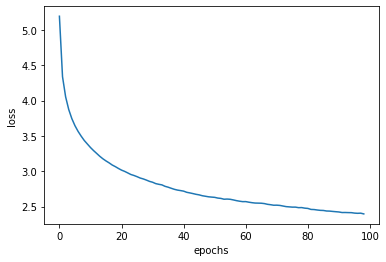

In [46]:
import pickle
import matplotlib.pyplot as plt
with open('J:/Flickr/n6/hisory_image_caption.pkl','rb') as f:
    file= pickle.load(f) 
for k,v in file.items():
    if(k=='loss'):
        plt.plot(v)
        
plt.xlabel('epochs')
plt.ylabel('loss')

In [44]:
#glove
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.536583
BLEU-2: 0.352434
BLEU-3: 0.246288
BLEU-4: 0.126269


[0.5365831762276686,
 0.3524337648355324,
 0.246287669309351,
 0.12626922662036633]

#### Test the model

In [46]:
#glove
# apprently model overfits badly after epoch 100. so im just gonna use the model from 60th epoch
i=99

model.load_weights('J:/Flickr/n6/model'+'/model_' + str(i) + '.h5')

In [47]:
#glove greedy
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.536583
BLEU-2: 0.352434
BLEU-3: 0.246288
BLEU-4: 0.126269


[0.5365831762276686,
 0.3524337648355324,
 0.246287669309351,
 0.12626922662036633]

In [48]:
#beam glove
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=3,log=True)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.414231
BLEU-2: 0.247458
BLEU-3: 0.178804
BLEU-4: 0.093028


[0.41423101473763757,
 0.2474583954153262,
 0.1788040793509202,
 0.0930279944254377]

In [49]:
#beam glove
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features,K_beams=5,log=True)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.403443
BLEU-2: 0.239854
BLEU-3: 0.171752
BLEU-4: 0.089355


[0.40344322163893886,
 0.23985357653068923,
 0.17175243991090094,
 0.08935525470221814]

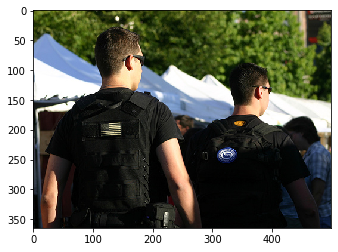

Greedy: একটি কালো এবং সাদা পোশাক পরা একটি মেয়ে একটি ভিড় ভিড় দেখছে।
Beam K= 3: পোশাক পরা এক ব্যক্তি একটি ছবির জন্য পোজ দিচ্ছেন।
Beam K= 5: একটি কালো এবং সাদা পোশাক পরা একটি মেয়ে একটি ভিড় ভিড় দেখছে।
Beam log K= 3: একটি কালো এবং সাদা পোশাক পরা একজন লোক একটি বিশাল ক্যামেরা ধারণ করছে।
Beam log K= 5: একটি কালো এবং সাদা পোশাক পরা একটি মেয়ে একটি ভিড় দেখছে।


In [50]:
pic = list(test_features.keys())[560]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

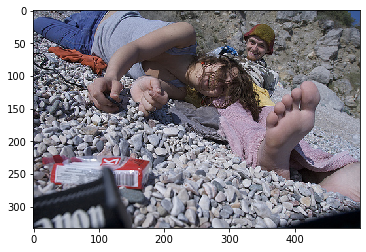

Greedy: একজন ব্যক্তি একটি বড় শিলায় বসে আছেন।
Beam K= 3: এক ব্যক্তি একটি বড় শিলায় বসে আছেন।
Beam K= 5: এক ব্যক্তি একটি বড় শিলায় বসে আছেন।
Beam log K= 3: একজন ব্যক্তি একটি বড় শিলায় বসে আছেন।
Beam log K= 5: একজন ব্যক্তি একটি বড় শিলায় বসে আছেন।


In [51]:
#glove
# 2417745327_a2c2705043.jpg#0	A brown dog runs through the water as a wave comes .
# 2417745327_a2c2705043.jpg#1	A brown dog runs through the water in the ocean .
# 2417745327_a2c2705043.jpg#2	A dog is running through the ocean .
# 2417745327_a2c2705043.jpg#3	The brown dog is running in the water .
# 2417745327_a2c2705043.jpg#4	The brown dog is running parallel to the waves in the water .

pic = list(test_features.keys())[2]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

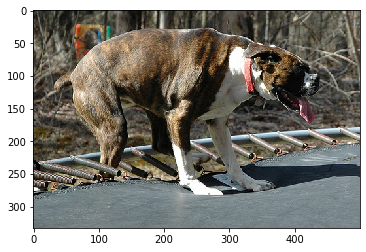

Greedy: একটি কুকুর একটি সৈকতে নেমেছে ।
Beam K= 3: একটি বাদামী কুকুর এবং একটি কালো কুকুর লড়াই করছে ।
Beam K= 5: দুটি কুকুর একে অপরের সাথে খেলছে ।
Beam log K= 3: একটি বাদামী কুকুর একটি বরফের মাঠ জুড়ে চলছে ।
Beam log K= 5: একটি কুকুর অন্য কুকুরটিকে তাড়া করছে ।


In [52]:
# 241347760_d44c8d3a01.jpg#0	A man is wearing a Sooners red football shirt and helmet .
# 241347760_d44c8d3a01.jpg#1	A Oklahoma Sooners football player wearing his jersey number 28 .
# 241347760_d44c8d3a01.jpg#2	A Sooners football player weas the number 28 and black armbands .
# 241347760_d44c8d3a01.jpg#3	Guy in red and white football uniform
# 241347760_d44c8d3a01.jpg#4	The American footballer is wearing a red and white strip .
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

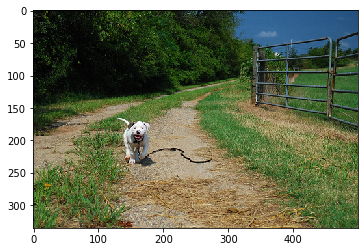

Greedy: একটি কুকুর একটি বেড়া দিয়ে ছুটে চলেছে ।
Beam K= 3: একটি সাদা কুকুর একটি ক্ষেতের মধ্য দিয়ে ছুটে চলেছে ।
Beam K= 5: একটি সাদা কুকুর একটি ক্ষেতের মধ্য দিয়ে ছুটে চলেছে ।
Beam log K= 3: একটি কুকুর একটি বেড়া দিয়ে ছুটে চলেছে ।
Beam log K= 5: একটি কুকুর একটি ক্ষেতের মধ্য দিয়ে ছুটে চলেছে ।


In [53]:
#glove
# 241347760_d44c8d3a01.jpg#0	A man is wearing a Sooners red football shirt and helmet .
# 241347760_d44c8d3a01.jpg#1	A Oklahoma Sooners football player wearing his jersey number 28 .
# 241347760_d44c8d3a01.jpg#2	A Sooners football player weas the number 28 and black armbands .
# 241347760_d44c8d3a01.jpg#3	Guy in red and white football uniform
# 241347760_d44c8d3a01.jpg#4	The American footballer is wearing a red and white strip .
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

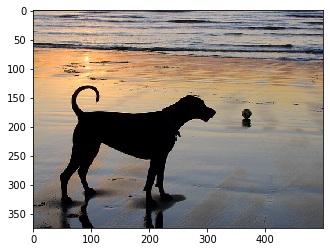

Greedy: একটি কালো কুকুর একটি সৈকতে দাঁড়িয়ে আছে ।
Beam K= 3: একটি কালো কুকুর সৈকতে দাঁড়িয়ে আছে ।
Beam K= 5: একটি কালো কুকুর সৈকতে দাঁড়িয়ে আছে ।
Beam log K= 3: একটি কালো কুকুর সৈকতে দাঁড়িয়ে আছে ।
Beam log K= 5: একটি কুকুর সৈকতে দাঁড়িয়ে আছে ।


In [54]:
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

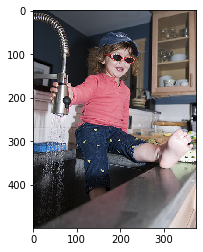

Greedy: একটি শিশু একটি বড় একটি বড় একটি বড় একটি প্রাচীরের উপর দিয়ে ঝাঁপিয়ে পড়ে।
Beam K= 3: একটি ছোট ছেলে একটি লাল শার্ট পরা একটি বিল্ডিং থেকে ঝাঁপিয়ে পড়ে ।
Beam K= 5: একটি অল্প বয়সী মেয়ে ক্যামেরা থেকে ঝাঁপিয়ে পড়ে ।
Beam log K= 3: একটি ছোট ছেলে একটি লাল শার্ট পরে একটি বিল্ডিং থেকে ঝাঁপিয়ে পড়ে ।
Beam log K= 5: একটি অল্প বয়সী মেয়ে একটি বিল্ডিং থেকে ঝাঁপিয়ে পড়ে ।


In [55]:
#glove
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

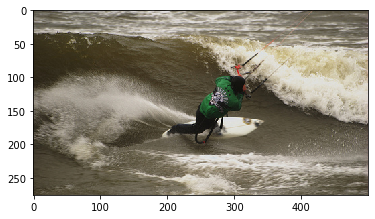

Greedy: একজন ব্যক্তি একটি বিশাল তরঙ্গ থেকে একটি বিশাল তরঙ্গ নিয়ে যাচ্ছেন।
Beam K= 3: একজন ব্যক্তি একটি বিশাল তরঙ্গ নিয়ে যাচ্ছেন।
Beam K= 5: একজন ব্যক্তি একটি বিশাল তরঙ্গ নিয়ে যাচ্ছেন।
Beam log K= 3: একজন ব্যক্তি পানিতে একটি সার্ফবোর্ডে
Beam log K= 5: একজন ব্যক্তি পানিতে একটি সার্ফবোর্ডে


In [56]:


pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

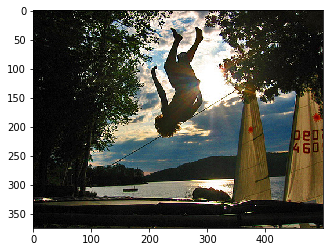

Greedy: একটি ছেলে একটি দোলায় লাফিয়ে।
Beam K= 3: একটি কালো এবং সাদা শার্টের একটি ছেলে পানির উপর দিয়ে লাফিয়ে।
Beam K= 5: একটি কালো এবং সাদা শার্টের একটি ছেলে পানির উপর দিয়ে লাফিয়ে।
Beam log K= 3: একটি কালো এবং সাদা শার্টের একটি ছেলে পানির উপর দিয়ে লাফিয়ে।
Beam log K= 5: একটি ছেলে অন্য ছেলেকে থেকে ঝাঁপিয়ে পড়ে।


In [57]:
#glove
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

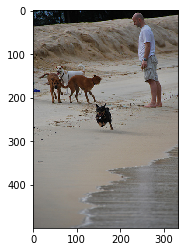

Greedy: তিনটি কুকুর একটি সৈকতে হাঁটছে ।
Beam K= 3: তিনটি কুকুর সৈকতে হাঁটছে ।
Beam K= 5: তিনটি কুকুর বালিতে হাঁটছে ।
Beam log K= 3: তিনটি কুকুর সৈকতে হাঁটছে ।
Beam log K= 5: তিনটি কুকুর সৈকতে হাঁটছে ।


In [58]:
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))

print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

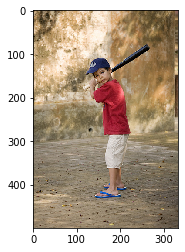

Greedy: একটি ছেলে একটি লাল ভবনের সামনে একটি জিনিস নিয়ে খেলছে।
Beam K= 3: একটি লাল শার্টের একটি লোক একটি বল হাতে নিয়ে একটি বিল্ডিং পেরিয়ে যাচ্ছেন।
Beam K= 5: নীল রঙের একটি শার্টের একটি লোক একটি লোকের সাথে একটি ছোট ছেলে।
Beam log K= 3: একটি লাল শার্টের একটি লোক একটি বল হাতে নিয়ে একটি লোকের দিকে তাকিয়ে আছে।
Beam log K= 5: নীল রঙের একটি শার্ট এবং একটি লাল শার্টের একটি লোক একটি লোকের সাথে একটি


In [59]:
#glove
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

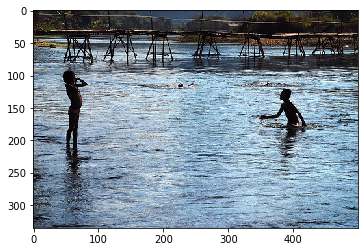

Greedy: একটি লোক একটি বিশাল উপর দিয়ে একটি উপর একটি উপর একটি উপর একটি উপর
Beam K= 3: একজন ব্যক্তি একটি উপর দিয়ে হাঁটছেন।
Beam K= 5: একদল লোক একটি উপর দিয়ে হাঁটছেন।
Beam log K= 3: একজন লোক একটি বিশাল উপর দিয়ে হাঁটছেন।
Beam log K= 5: এক ব্যক্তি একটি বিশাল দেহে উপর দিয়ে হাঁটছেন।


In [60]:
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))

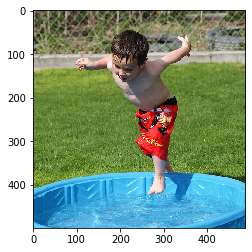

Greedy: একটি ছেলে একটি পুলে লাফিয়ে ।
Beam K= 3: একটি ছোট ছেলে একটি পুলে লাফিয়ে ।
Beam K= 5: একটি ছোট ছেলে একটি পুলে লাফিয়ে ।
Beam log K= 3: একটি ছেলে একটি পুলে লাফিয়ে ।
Beam log K= 5: একটি ছেলে একটি পুলে লাফিয়ে ।


In [61]:
#glove
pic = list(test_features.keys())[np.random.randint(1,1000)]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('J:/Flickr_Data/FlickrBn8000/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=True))